# Processing stackSentinel over CA

In [1]:
import os
#os.environ["OMP_NUM_THREADS"] = "4" # export OMP_NUM_THREADS=4
#os.environ["OPENBLAS_NUM_THREADS"] = "1" # export OPENBLAS_NUM_THREADS=4 
#os.environ["MKL_NUM_THREADS"] = "6" # export MKL_NUM_THREADS=6
#os.environ["VECLIB_MAXIMUM_THREADS"] = "4" # export VECLIB_MAXIMUM_THREADS=4
#os.environ["NUMEXPR_NUM_THREADS"] = "6" # export NUMEXPR_NUM_THREADS=6

In [2]:
import site
from pathlib import Path
import subprocess
import numpy as np
import time
import zipfile

import requests
from lxml import etree
import urllib.request
from urllib.parse import urljoin

import rasterio
from rasterio import logging
log = logging.getLogger()
log.setLevel(logging.ERROR)

import pandas as pd
import geopandas as gpd
from shapely.geometry import box
from shapely import Polygon

# Plotting modules
from IPython import display
from cartopy import crs as ccrs
from matplotlib import pyplot as plt
import cartopy.io.img_tiles as cimgt

# isce2
import isce
isce_application_path = Path(isce.isce_path) / 'applications'
os.environ['PATH'] += (':' + str(isce_application_path))

# TopsStack aux modules
import asf_search as asf
import eof 
from dem_stitcher.stitcher import stitch_dem

/home/govorcin/tools/miniconda3/envs/insar/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Additional functions
def make_geodataframe(asf_seach_object):
    df = pd.DataFrame(asf_seach_object.properties, dtype=str, index=[0])
    df['wkt'] = Polygon(asf_seach_object.geometry['coordinates'][0]).wkt
    gs = gpd.GeoSeries.from_wkt(df['wkt'])
    gdf = gpd.GeoDataFrame(df, geometry=gs, crs="EPSG:4326")
    return gdf

def tag_dem_xml_as_ellipsoidal(dem_path: Path) -> str:
    xml_path = str(dem_path) + '.xml'
    assert(Path(xml_path).exists())
    tree = etree.parse(xml_path)
    root = tree.getroot()

    y = etree.Element("property", name='reference')
    etree.SubElement(y, "value").text = "WGS84"
    etree.SubElement(y, "doc").text = "Geodetic datum"

    root.insert(0, y)
    with open(xml_path, 'wb') as file:
        file.write(etree.tostring(root, pretty_print=True))
    return xml_path


def fix_image_xml(isce_raster_path: str) -> str:
    isce_application_path = Path(f'{site.getsitepackages()[0]}'
                                '/isce/applications/')

    fix_cmd = [f'{isce_application_path}/fixImageXml.py',
               '-i',
               str(isce_raster_path),
               '--full']
    fix_cmd_line = ' '.join(fix_cmd)
    subprocess.check_call(fix_cmd_line, shell=True)
    print(fix_cmd_line)
    return isce_raster_path


def download_dem_for_isce2(extent: list,
                           dem_name: str = 'glo_30',
                           dem_dir: Path = None,
                           dem_res = 0.0002777777777777777775,
                           buffer: float = .004) -> dict:
    """
    Parameters
    ----------
    extent : list
        [xmin, ymin, xmax, ymin] for epsg:4326 (i.e. (x, y) = (lon, lat))
    dem_name : str, optional
        See names in `dem_stitcher`
    dem_dir: Path, optional
        
    buffer : float, optional
        In degrees, by default .001, which is .5 km at equator
    Returns
    -------
    Path
    """
    dem_dir = dem_dir or Path(f'{dem_name}')
    dem_dir.mkdir(exist_ok=True, parents=True)

    extent_geo = box(*extent)
    extent_buffered = list(extent_geo.buffer(buffer).bounds)
    extent_buffered = [np.floor(extent_buffered[0]), np.floor(extent_buffered[1]),
                       np.ceil(extent_buffered[2]), np.ceil(extent_buffered[3])]

    # you can remove this parameter if you don't mind resolution of original DEM
    dem_array, dem_profile = stitch_dem(extent_buffered,
                                        dem_name,
                                        dst_ellipsoidal_height=True,
                                        dst_area_or_point='Point',
                                        # ensures square resolution
                                        dst_resolution=dem_res
                                        )

    dem_path = dem_dir / 'full_res.dem.wgs84'
    print(dem_path)
    dem_array[np.isnan(dem_array)] = 0.

    dem_profile_isce = dem_profile.copy()
    dem_profile_isce['nodata'] = None
    dem_profile_isce['driver'] = 'ISCE'
    # remove keys that do not work with ISCE gdal format
    [dem_profile_isce.pop(key) for key in ['blockxsize', 'blockysize', 'compress', 'interleave', 'tiled']]

    with rasterio.open(dem_path, 'w', **dem_profile_isce) as ds:
        ds.write(dem_array, 1)
        
    dem_xml = tag_dem_xml_as_ellipsoidal(dem_path)
    fix_image_xml(dem_xml)

    return dem_xml

# Adjustable parameters

In [4]:
# Work Directory and Area of Interest
work_dir = Path('/u/trappist-r0/govorcin/CA/')
aoi = [37, 39, -120.5, -118] # snwe 

# Download parameters
track = 144
start_date = '2023-02-01'
end_date = '2023-04-10'
flight_direction = 'DSC'
n_processes = 50 # number of threads for downloading SLCs
dem_name = 'glo_30'

In [6]:
## Set-up processing directory structure

# Sentinel-1 SLCs folder
slc_dir = work_dir / flight_direction / str(track) / 'data'
slc_dir.mkdir(exist_ok=True, parents=True)

# GLO-30 DEM folder
dem_dir = work_dir / 'DEM'
dem_dir.mkdir(exist_ok=True, parents=True)
dem_path = dem_dir / 'full_res.dem.wgs84'

# Sentinel-1 ORBIT data folder
orbit_dir = work_dir / 'ORBIT'
orbit_dir.mkdir(exist_ok=True, parents=True)

# Sentinel-1 AUX CAL-file folder
aux_dir = work_dir / 'AUX'
aux_dir.mkdir(exist_ok=True, parents=True)

# stackSentinel dir
isce_run_dir = slc_dir.parent / 'isce'
isce_run_dir.mkdir(exist_ok=True, parents=True)

run_dir = isce_run_dir / 'run_files'
run_ifg_dir = isce_run_dir / 'run_ifg_files'

## Download Sentinel-1 images

In [7]:
# Create aoi_polygon
aoi_polygon = Polygon([(aoi[2], aoi[0]), (aoi[3], aoi[0]),
                       (aoi[3], aoi[1]), (aoi[2], aoi[1])])
                       
# Increase the aoi for 0.1 deg by adding buffer
aoi_polygon = aoi_polygon.buffer(0.1) 

# Prepare flight_directionf for asf_search
if flight_direction.casefold().startswith('asc'):
    orbit = asf.ASCENDING
elif flight_direction.casefold().startswith('dsc'):
    orbit = asf.DESCENDING 
else:
    raise ValueError(f'Selected flight direction \033[1m"{flight_direction}"\033[0m'
                     f' does not exist! \n '   
                     f'            Available options: "Ascending" or "Descending"')

In [41]:
# Find number of available Sentinel-1 images
search_results = asf.geo_search(
    platform=asf.SENTINEL1,
    intersectsWith=aoi_polygon.wkt,
    start= start_date,
    end=end_date,
    processingLevel=asf.SLC,
    beamMode=asf.IW,
    relativeOrbit=track, # Change the path
    flightDirection=orbit,
)
print(f'Available {len(search_results)} Sentinel-1 SLCs to download!')


# Loop to all search results
gdfs = [make_geodataframe(result) for result in search_results]

#Concatante
gdfs = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True),
                        geometry='geometry', crs="EPSG:4326")

# Get the preview of Dataframe
gdfs.head()

2023-06-01 09:55:34,911 - root - INFO - 'type': 'GEOMETRY_SIMPLIFICATION'
	'report': 'Shape Simplified: shape of 68 simplified to 20 with proximity threshold of 0.004'
2023-06-01 09:55:34,913 - root - INFO - 'type': 'REVERSE'
	'report': Reversed polygon winding order
2023-06-01 09:55:36,159 - urllib3.connectionpool - DEBUG - https://cmr.earthdata.nasa.gov:443 "POST /search/granules.umm_json_v1_4 HTTP/1.1" 200 None
2023-06-01 09:55:36,642 - urllib3.connectionpool - DEBUG - https://cmr.earthdata.nasa.gov:443 "POST /search/granules.umm_json_v1_4 HTTP/1.1" 200 33
Available 18 Sentinel-1 SLCs to download!


beamModeType browse       bytes centerLat  centerLon faradayRotation  \
0           IW   None  4503422199   36.2229  -119.3537            None   
1           IW   None  4538214320   37.7174  -119.0324            None   
2           IW   None  4453868856   39.2395  -118.6969            None   
3           IW   None  4501626659   36.2224  -119.3529            None   
4           IW   None  4522912582   37.7168  -119.0315            None   

                                              fileID flightDirection  \
0  S1A_IW_SLC__1SDV_20230407T140019_20230407T1400...      DESCENDING   
1  S1A_IW_SLC__1SDV_20230407T135954_20230407T1400...      DESCENDING   
2  S1A_IW_SLC__1SDV_20230407T135928_20230407T1359...      DESCENDING   
3  S1A_IW_SLC__1SDV_20230326T140018_20230326T1400...      DESCENDING   
4  S1A_IW_SLC__1SDV_20230326T135954_20230326T1400...      DESCENDING   

                         groupID        granuleType  ...  \
0  S1A_IWDV_0471_0477_047991_144  SENTINEL_1A_FRAME  ...   
1  S1A_IWDV_0466_0472_047991_144  SENTINEL_1A_FRAME  ...   
2  S1A_IWDV_0461_0467_047991_144  SENTINEL_1A_FRAME  ...   
3  S1A_IWDV_0472_0477_047816_144  SENTINEL_1A_FRAME  ...   
4  S1A_IWDV_0467_0472_047816_144  SENTINEL_1A_FRAME  ...   

                                           sceneName sensor  \
0  S1A_IW_SLC__1SDV_20230407T140019_20230407T1400...  C-SAR   
1  S1A_IW_SLC__1SDV_20230407T135954_20230407T1400...  C-SAR   
2  S1A_IW_SLC__1SDV_20230407T135928_20230407T1359...  C-SAR   
3  S1A_IW_SLC__1SDV_20230326T140018_20230326T1400...  C-SAR   
4  S1A_IW_SLC__1SDV_20230326T135954_20230326T1400...  C-SAR   

                  startTime                  stopTime  \
0  2023-04-07T14:00:19.000Z  2023-04-07T14:00:46.000Z   
1  2023-04-07T13:59:54.000Z  2023-04-07T14:00:21.000Z   
2  2023-04-07T13:59:28.000Z  2023-04-07T13:59:56.000Z   
3  2023-03-26T14:00:18.000Z  2023-03-26T14:00:45.000Z   
4  2023-03-26T13:59:54.000Z  2023-03-26T14:00:21.000Z   

                                                 url pgeVersion  \
0  https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...     003.61   
1  https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...     003.61   
2  https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...     003.61   
3  https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...     003.52   
4  https://datapool.asf.alaska.edu/SLC/SA/S1A_IW_...     003.52   

                                            fileName frameNumber  \
0  S1A_IW_SLC__1SDV_20230407T140019_20230407T1400...         471   
1  S1A_IW_SLC__1SDV_20230407T135954_20230407T1400...         466   
2  S1A_IW_SLC__1SDV_20230407T135928_20230407T1359...         461   
3  S1A_IW_SLC__1SDV_20230326T140018_20230326T1400...         471   
4  S1A_IW_SLC__1SDV_20230326T135954_20230326T1400...         466   

                                                 wkt  \
0  POLYGON ((-118.152458 35.203022, -117.764137 3...   
1  POLYGON ((-117.80928 36.698856, -117.413353 38...   
2  POLYGON ((-117.456123 38.193264, -117.03714 39...   
3  POLYGON ((-118.151764 35.202526, -117.763382 3...   
4  POLYGON ((-117.808502 36.698223, -117.412514 3...   

                                            geometry  
0  POLYGON ((-118.15246 35.20302, -117.76414 36.8...  
1  POLYGON ((-117.80928 36.69886, -117.41335 38.3...  
2  POLYGON ((-117.45612 38.19326, -117.03714 39.8...  
3  POLYGON ((-118.15176 35.20253, -117.76338 36.8...  
4  POLYGON ((-117.80850 36.69822, -117.41251 38.3...  

[5 rows x 30 columns]

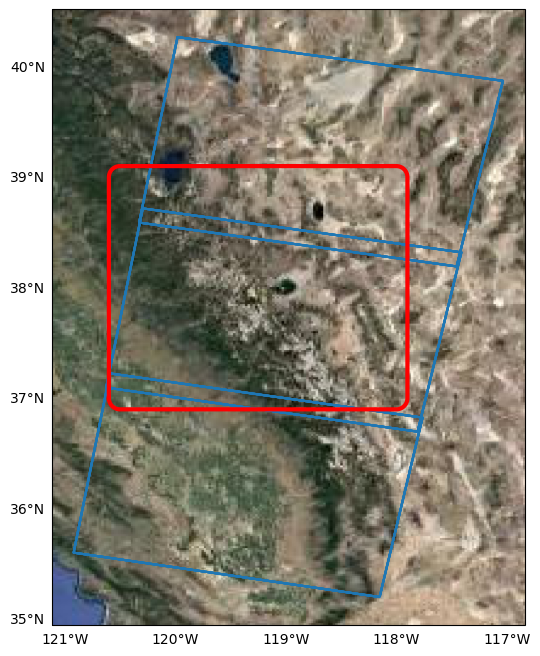

In [120]:
# Plot the results
fig, ax = plt.subplots(1, figsize=[12,8], subplot_kw=dict(projection=ccrs.PlateCarree()))
image = cimgt.GoogleTiles(url = 'https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}')
ax.add_image(image, 6, cmap='gray', zorder=0)
gdfs.exterior.plot(ax=ax)
ax.plot(aoi_polygon.exterior.xy[0], aoi_polygon.exterior.xy[1], 'r-', linewidth=3)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.right_labels = False
gl.xlines = False
gl.ylines = False


In [45]:
# Download
search_results.download(
     path = str(slc_dir), 
     processes = n_processes
  )

2023-06-01 09:57:00,170 - asf_search - INFO - Started downloading ASFSearchResults of size 18.
2023-06-01 09:57:00,172 - asf_search - INFO - Using 50 threads - starting up pool.


/home/govorcin/tools/miniconda3/envs/insar/lib/python3.8/site-packages/asf_search/download/download.py:65: UserWarning: File already exists, skipping download: /u/trappist-r0/govorcin/CA/DSC/144/data/S1A_IW_SLC__1SDV_20230206T135928_20230206T135956_047116_05A706_E9C3.zip
  warnings.warn(f'File already exists, skipping download: {os.path.join(path, filename)}')
/home/govorcin/tools/miniconda3/envs/insar/lib/python3.8/site-packages/asf_search/download/download.py:65: UserWarning: File already exists, skipping download: /u/trappist-r0/govorcin/CA/DSC/144/data/S1A_IW_SLC__1SDV_20230206T140018_20230206T140045_047116_05A706_7CD5.zip
  warnings.warn(f'File already exists, skipping download: {os.path.join(path, filename)}')
/home/govorcin/tools/miniconda3/envs/insar/lib/python3.8/site-packages/asf_search/download/download.py:65: UserWarning: File already exists, skipping download: /u/trappist-r0/govorcin/CA/DSC/144/data/S1A_IW_SLC__1SDV_20230326T135928_20230326T135956_047816_05BEAF_31A5.zip
  

2023-06-01 09:57:00,491 - asf_search - INFO - Finished downloading ASFSearchResults of size 18.


## Download DEM
https://github.com/ACCESS-Cloud-Based-InSAR/dem-stitcher

In [49]:
download_dem_for_isce2(extent=[aoi[2], aoi[0], aoi[3], aoi[1]],
                       dem_name=dem_name,
                       dem_dir=dem_dir,
                       buffer=0.5)

Reading glo_30 Datasets: 100%|██████████| 16/16 [00:08<00:00,  1.90it/s]


/u/trappist-r0/govorcin/CA/DEM/full_res.dem.wgs84
fixing xml file path for file: /u/trappist-r0/govorcin/CA/DEM/full_res.dem.wgs84
Writing geotrans to VRT for /u/trappist-r0/govorcin/CA/DEM/full_res.dem.wgs84
/home/govorcin/tools/miniconda3/envs/insar/lib/python3.8/site-packages/isce/applications/fixImageXml.py -i /u/trappist-r0/govorcin/CA/DEM/full_res.dem.wgs84.xml --full


'/u/trappist-r0/govorcin/CA/DEM/full_res.dem.wgs84.xml'

## Download ORBIT
https://github.com/scottstanie/sentineleof/blob/master/eof/download.py

In [22]:
eof.download.main(search_path=slc_dir, save_dir=orbit_dir)

/home/govorcin/tools/miniconda3/envs/insar/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


0

## AUX DATA
https://aux.sentinel1.eo.esa.int/

In [118]:
## NEED TO VERIFY THAT AUX_DATA ARE INGESTED CORRECTLY WITH STACKSENTINEL

url = 'https://sar-mpc.eu/ipf-adf/aux_cal/?adf__active=True'
response = requests.get(url)
response.raise_for_status()
page_content = response.text

file_urls = []
file_names = []
start_marker = '<a href="'
end_marker = '</a>'
start_index = page_content.find(start_marker)
while start_index != -1:
    end_index = page_content.find(end_marker, start_index + len(start_marker))
    file_url = page_content[start_index + len(start_marker):end_index]
    if file_url.startswith('/download'):
        file_urls.append(file_url.split('">')[0])
        file_names.append(file_url.split('">')[1])
    start_index = page_content.find(start_marker, end_index)

# Download
for file_name, file_url in zip(file_names, file_urls):
    file_path = aux_dir / file_name
    file_path = file_path.with_suffix('.zip')

    if file_path.exists() or file_path.stem + '.SAFE':
        print(f'SKIP \033[1m{file_path.stem}\033[0m exists')
    else:
        response = requests.get(urljoin(url, file_url))
        response.raise_for_status()
        file_path.write_bytes(response.content)
        
        with zipfile.ZipFile(file_path, 'r') as zip_ref:
            zip_ref.extractall(aux_dir)
        file_path.unlink()
        print(f"Downloaded: {file_name}")

SKIP S1B_AUX_CAL_V20190514T090000_G20210104T140612 exists
SKIP S1A_AUX_CAL_V20190228T092500_G20210104T141310 exists
SKIP S1A_AUX_CAL_V20171017T080000_G20210104T141000 exists
SKIP S1A_AUX_CAL_V20160627T000000_G20190626T100501 exists
SKIP S1B_AUX_CAL_V20160422T000000_G20210104T140113 exists
SKIP S1A_AUX_CAL_V20150722T120000_G20190626T100253 exists
SKIP S1A_AUX_CAL_V20150519T120000_G20190626T100229 exists
SKIP S1A_AUX_CAL_V20140908T000000_G20190626T100201 exists
SKIP S1A_AUX_CAL_V20140616T133500_G20190626T100133 exists
SKIP S1A_AUX_CAL_V20140406T133000_G20190626T100036 exists
SKIP S1A_AUX_CAL_V20140402T000000_G20140402T133909 exists


# Stack Sentinel - make coregistrated SLC stack

In [8]:
# We need to add isce2/contrib/stack/ directory to our PATH env variable
isce2_stack_dir = Path('/home/govorcin/tools/isce22/src/isce2/contrib/stack')
os.environ['PATH'] += (':' + str(isce2_stack_dir / 'topsStack'))
os.environ['PYTHONPATH'] = str(isce2_stack_dir) 

# Go to work_dir processing directory
os.chdir(isce_run_dir)
print(f'Work directory; {os.getcwd()}')

Work directory; /u/trappist-r0/govorcin/CA/DSC/144/isce


In [128]:
# Generate config and run file for generation of coregistrated SLCs

processing_bound = ' '.join(str(x) for x in aoi) # SNWE
args = f'stackSentinel.py -s {slc_dir} -d {dem_path} -b "{processing_bound}" -a {aux_dir} -o {orbit_dir} -C NESD  -W slc'
args += ' --num_proc4topo 10 --num_proc 10' # to add multi threading
print(args)

# Creates configs and run_files
subprocess.run(args, shell=True, close_fds=True)

# List created run files
run_files = list(run_dir.glob('run_*'))
print(f'Number of run files: {len(run_files)}')
run_files

stackSentinel.py -s /u/trappist-r0/govorcin/CA/DSC/144/data -d /u/trappist-r0/govorcin/CA/DEM/full_res.dem.wgs84 -b "37 39 -120.5 -118" -a /u/trappist-r0/govorcin/CA/AUX -o /u/trappist-r0/govorcin/CA/ORBIT -C NESD  -W slc --num_proc4topo 10 --num_proc 10

**************************
run_files folder exists.
/u/trappist-r0/govorcin/CA/DSC/144/isce/run_files  already exists.
Please remove or rename this folder and try again.

**************************
Number of run files: 13


[PosixPath('/u/trappist-r0/govorcin/CA/DSC/144/isce/run_files/run_01_unpack_topo_reference'),
 PosixPath('/u/trappist-r0/govorcin/CA/DSC/144/isce/run_files/run_02_unpack_secondary_slc'),
 PosixPath('/u/trappist-r0/govorcin/CA/DSC/144/isce/run_files/run_03_average_baseline'),
 PosixPath('/u/trappist-r0/govorcin/CA/DSC/144/isce/run_files/run_04_extract_burst_overlaps'),
 PosixPath('/u/trappist-r0/govorcin/CA/DSC/144/isce/run_files/run_05_overlap_geo2rdr'),
 PosixPath('/u/trappist-r0/govorcin/CA/DSC/144/isce/run_files/run_06_overlap_resample'),
 PosixPath('/u/trappist-r0/govorcin/CA/DSC/144/isce/run_files/run_07_pairs_misreg'),
 PosixPath('/u/trappist-r0/govorcin/CA/DSC/144/isce/run_files/run_08_timeseries_misreg'),
 PosixPath('/u/trappist-r0/govorcin/CA/DSC/144/isce/run_files/run_09_fullBurst_geo2rdr'),
 PosixPath('/u/trappist-r0/govorcin/CA/DSC/144/isce/run_files/run_10_fullBurst_resample'),
 PosixPath('/u/trappist-r0/govorcin/CA/DSC/144/isce/run_files/run_11_extract_stack_valid_region'

In [25]:
# Step 1 - unpack_topo_reference
# Directory: reference and geom_reference
run_file = list(run_dir.glob('run_01*'))[0]
print(f'RUNNING {run_file}!')
run_file.chmod(33791)
out = subprocess.run(str(run_file), shell=True, check=True, stdout=subprocess.PIPE, close_fds=True)
print(out.stdout.decode("utf-8"))
print('STEP FINISHED - SUCESS!!!' if  out.returncode == 0 else 'STEP FINISHED - FAILED!!!')

RUNNING /u/trappist-r0/govorcin/CA/DSC/144/isce/run_files/run_01_unpack_topo_reference!


OSError: [Errno 8] Exec format error: '/u/trappist-r0/govorcin/CA/DSC/144/isce/run_files/run_01_unpack_topo_reference'

In [27]:
# Step 2
# Directory: secondarys 
run_file = list(run_dir.glob('run_02*'))[0]
print(f'RUNNING {run_file}!')
run_file.chmod(33791)
out = subprocess.run(str(run_file), shell=True, check=True, stdout=subprocess.PIPE, close_fds=True)
print(out.stdout.decode("utf-8"))
print('STEP FINISHED - SUCESS!!!' if  out.returncode == 0 else 'STEP FINISHED - FAILED!!!')

RUNNING /u/trappist-r0/govorcin/CA/DSC/144/isce/run_files/run_02_unpack_secondary_slc!


CompletedProcess(args='/u/trappist-r0/govorcin/CA/DSC/144/isce/run_files/run_02_unpack_secondary_slc', returncode=0)

Completed Parsing the Configuration file
Functions to be executed:
['Function-1']
Running: Sentinel1_TOPS
['--dirname', '/u/trappist-r0/govorcin/CA/DSC/144/data/S1A_IW_SLC__1SDV_20230407T135928_20230407T135956_047991_05C496_0F24.zip /u/trappist-r0/govorcin/CA/DSC/144/data/S1A_IW_SLC__1SDV_20230407T135954_20230407T140021_047991_05C496_9041.zip /u/trappist-r0/govorcin/CA/DSC/144/data/S1A_IW_SLC__1SDV_20230407T140019_20230407T140046_047991_05C496_FACC.zip', '--swaths', '1 2 3', '--orbitdir', '/u/trappist-r0/govorcin/CA/ORBIT', '--outdir', '/u/trappist-r0/govorcin/CA/DSC/144/isce/secondarys/20230407', '--auxdir', '/u/trappist-r0/AuxDir', '--bbox', '37 39 -120.5 -118', '--pol', 'vv']
Completed Parsing the Configuration file
Functions to be executed:
['Function-1']
Running: Sentinel1_TOPS
['--dirname', '/u/trappist-r0/govorcin/CA/DSC/144/data/S1A_IW_SLC__1SDV_20230302T135928_20230302T135956_047466_05B2DB_B7AF.zip /u/trappist-r0/govorcin/CA/DSC/144/data/S1A_IW_SLC__1SDV_20230302T135953_202303

In [55]:
# Step 3 average baseline
# Directory: baselines
run_file = list(run_dir.glob('run_03*'))[0]
print(f'RUNNING {run_file}!')
run_file.chmod(33791)
out = subprocess.run(str(run_file), shell=True, check=True, stdout=subprocess.PIPE, close_fds=True)
print(out.stdout.decode("utf-8"))
print('STEP FINISHED - SUCESS!!!' if  out.returncode == 0 else 'STEP FINISHED - FAILED!!!')

RUNNING /u/trappist-r0/govorcin/CA/DSC/144/isce/run_files/run_03_average_baseline!
Completed Parsing the Configuration file
Functions to be executed:
['Function-1']
Running: computeBaseline
['--reference', '/u/trappist-r0/govorcin/CA/DSC/144/isce/reference/', '--secondary', '/u/trappist-r0/govorcin/CA/DSC/144/isce/secondarys/20230407', '--baseline_file', '/u/trappist-r0/govorcin/CA/DSC/144/isce/baselines/20230206_20230407/20230206_20230407.txt']
Completed Parsing the Configuration file
Functions to be executed:
['Function-1']
Running: computeBaseline
['--reference', '/u/trappist-r0/govorcin/CA/DSC/144/isce/reference/', '--secondary', '/u/trappist-r0/govorcin/CA/DSC/144/isce/secondarys/20230218', '--baseline_file', '/u/trappist-r0/govorcin/CA/DSC/144/isce/baselines/20230206_20230218/20230206_20230218.txt']
Completed Parsing the Configuration file
Functions to be executed:
['Function-1']
Completed Parsing the Configuration fileCompleted Parsing the Configuration file

Functions to be exe

In [56]:
# Step 4 extract_burst_overlaps
# Directory: reference/overlap
run_file = list(run_dir.glob('run_04*'))[0]
print(f'RUNNING {run_file}!')
run_file.chmod(33791)

out = subprocess.run(str(run_file), shell=True, check=True, stdout=subprocess.PIPE, close_fds=True)
print(out.stdout.decode("utf-8"))
print('STEP FINISHED - SUCESS!!!' if  out.returncode == 0 else 'STEP FINISHED - FAILED!!!')

RUNNING /u/trappist-r0/govorcin/CA/DSC/144/isce/run_files/run_04_extract_burst_overlaps!
Overlap 0 start time - IW-1 2023-02-06 13:59:43.850665 subset
Overlap 0 stop time - IW-1 2023-02-06 13:59:44.169276 subset
Overlap 0 number of lines - IW-1 156 subset
Overlap 0 number of valid lines - IW-1 120 subset
Top:  ['/u/trappist-r0/govorcin/CA/DSC/144/isce/reference/overlap/IW1/burst_top_01_02.slc']
Bottom:  ['/u/trappist-r0/govorcin/CA/DSC/144/isce/reference/overlap/IW1/burst_bot_01_02.slc']
Overlap 1 start time - IW-1 2023-02-06 13:59:46.609222 subset
Overlap 1 stop time - IW-1 2023-02-06 13:59:46.929888 subset
Overlap 1 number of lines - IW-1 157 subset
Overlap 1 number of valid lines - IW-1 121 subset
Top:  ['/u/trappist-r0/govorcin/CA/DSC/144/isce/reference/overlap/IW1/burst_top_01_02.slc', '/u/trappist-r0/govorcin/CA/DSC/144/isce/reference/overlap/IW1/burst_top_02_03.slc']
Bottom:  ['/u/trappist-r0/govorcin/CA/DSC/144/isce/reference/overlap/IW1/burst_bot_01_02.slc', '/u/trappist-r0/go

In [57]:
# Step 5 overlap_geo2rdr
# Directory: coreg_secondarys
run_file = list(run_dir.glob('run_05*'))[0]
print(f'RUNNING {run_file}!')
run_file.chmod(33791)
out = subprocess.run(str(run_file), shell=True, check=True, stdout=subprocess.PIPE, close_fds=True)
print(out.stdout.decode("utf-8"))
print('STEP FINISHED - SUCESS!!!' if  out.returncode == 0 else 'STEP FINISHED - FAILED!!!')

RUNNING /u/trappist-r0/govorcin/CA/DSC/144/isce/run_files/run_05_overlap_geo2rdr!
Completed Parsing the Configuration file
Functions to be executed:
['Function-1']
Running: geo2rdr
['--secondary', '/u/trappist-r0/govorcin/CA/DSC/144/isce/secondarys/20230218', '--reference', '/u/trappist-r0/govorcin/CA/DSC/144/isce/reference', '--geom_referenceDir', '/u/trappist-r0/govorcin/CA/DSC/144/isce/geom_reference', '--coregSLCdir', '/u/trappist-r0/govorcin/CA/DSC/144/isce/coreg_secondarys/20230218', '--overlap']
Completed Parsing the Configuration file
Functions to be executed:
['Function-1']
Completed Parsing the Configuration file
Functions to be executed:
['Function-1']
Completed Parsing the Configuration file
Functions to be executed:
['Function-1']
Running: geo2rdr
['--secondary', '/u/trappist-r0/govorcin/CA/DSC/144/isce/secondarys/20230302', '--reference', '/u/trappist-r0/govorcin/CA/DSC/144/isce/reference', '--geom_referenceDir', '/u/trappist-r0/govorcin/CA/DSC/144/isce/geom_reference', '

In [58]:
# Step 6 overlap_resample
# Directory: coreg_secondarys
run_file = list(run_dir.glob('run_06*'))[0]
print(f'RUNNING {run_file}!')
run_file.chmod(33791)
out = subprocess.run(str(run_file), shell=True, check=True, stdout=subprocess.PIPE, close_fds=True)
print(out.stdout.decode("utf-8"))
print('STEP FINISHED - SUCESS!!!' if  out.returncode == 0 else 'STEP FINISHED - FAILED!!!')

RUNNING /u/trappist-r0/govorcin/CA/DSC/144/isce/run_files/run_06_overlap_resample!
Completed Parsing the Configuration file
Functions to be executed:
['Function-1']
Running: resamp_withCarrier
['--secondary', '/u/trappist-r0/govorcin/CA/DSC/144/isce/secondarys/20230302', '--reference', '/u/trappist-r0/govorcin/CA/DSC/144/isce/reference', '--coregdir', '/u/trappist-r0/govorcin/CA/DSC/144/isce/coreg_secondarys/20230302', '--overlap']
Completed Parsing the Configuration file
Functions to be executed:
['Function-1']
Running: resamp_withCarrier
['--secondary', '/u/trappist-r0/govorcin/CA/DSC/144/isce/secondarys/20230326', '--reference', '/u/trappist-r0/govorcin/CA/DSC/144/isce/reference', '--coregdir', '/u/trappist-r0/govorcin/CA/DSC/144/isce/coreg_secondarys/20230326', '--overlap']
Completed Parsing the Configuration file
Functions to be executed:
['Function-1']
Completed Parsing the Configuration file
Functions to be executed:
['Function-1']
Running: resamp_withCarrier
['--secondary', '/u

In [59]:
# Step 7 pairs_misreg
# Directory: ESD 
run_file = list(run_dir.glob('run_07*'))[0]
print(f'RUNNING {run_file}!')
run_file.chmod(33791)
out = subprocess.run(str(run_file), shell=True, check=True, stdout=subprocess.PIPE, close_fds=True)
print(out.stdout.decode("utf-8"))
print('STEP FINISHED - SUCESS!!!' if  out.returncode == 0 else 'STEP FINISHED - FAILED!!!')

RUNNING /u/trappist-r0/govorcin/CA/DSC/144/isce/run_files/run_07_pairs_misreg!


sh: looks.py: command not found
Traceback (most recent call last):
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/SentinelWrapper.py", line 251, in <module>
    main(args.start,args.end)
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/SentinelWrapper.py", line 242, in main
    cfgParser.runCmd()
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/SentinelWrapper.py", line 54, in runCmd
    func_modules.main(self.funcParams[section])
  File "/u/trappist0/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/overlap_withDEM.py", line 354, in main
    multIntName= multilook(intName, alks = inps.esdAzimuthLooks, rlks=inps.esdRangeLooks)
  File "/u/trappist0/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/overlap_withDEM.py", line 50, in multilook
    raise Exception('Failed to multilook %s'%(intName))
Exception: Failed to multilook /u/trappist-r0/govorcin/CA/DSC/144/isce/ESD/20230302_20230326/IW1/overlap_01.int
sh: lo

KeyboardInterrupt: 

Traceback (most recent call last):
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/SentinelWrapper.py", line 251, in <module>
    main(args.start,args.end)
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/SentinelWrapper.py", line 242, in main
    cfgParser.runCmd()
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/SentinelWrapper.py", line 54, in runCmd
    func_modules.main(self.funcParams[section])
  File "/u/trappist0/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/generateIgram.py", line 205, in main
    intimage = multiply(referencename, secondaryname, intname,
  File "/u/trappist0/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/generateIgram.py", line 68, in multiply
    print('read')
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/SentinelWrapper.py", line 251, in <module>
    main(args.start,args.end)
  

In [28]:
# Step 8 pairs_misreg
# Directory: timeseries_misreg
run_file = list(run_dir.glob('run_08*'))[0]
print(f'RUNNING {run_file}!')
run_file.chmod(33791)
out = subprocess.run(str(run_file), shell=True, check=True, stdout=subprocess.PIPE)
print(out.stdout.decode("utf-8"))
print('STEP FINISHED - SUCESS!!!' if  out.returncode == 0 else 'STEP FINISHED - FAILED!!!')

RUNNING /u/trappist-r0/govorcin/CA/DSC/144/isce/run_files/run_08_timeseries_misreg!


Traceback (most recent call last):
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/invertMisreg.py", line 158, in <module>
    main()
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/invertMisreg.py", line 114, in main
    tbase,dateList,dateDict = date_list(overlapPairs)
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/invertMisreg.py", line 50, in date_list
    d1 = datetime.datetime(*time.strptime(dateList[0],"%Y%m%d")[0:5])
IndexError: list index out of range
Traceback (most recent call last):
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/invertMisreg.py", line 158, in <module>
    main()
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/invertMisreg.py", line 114, in main
    tbase,dateList,dateDict = date_list(overlapPairs)
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/invertMisreg.py", line 50, in date_list
    d1 = datetime.datetime(*time.strptime(

CalledProcessError: Command '/u/trappist-r0/govorcin/CA/DSC/144/isce/run_files/run_08_timeseries_misreg' returned non-zero exit status 1.

In [60]:
# Step 9 pairs_misreg
# Directory: fullBurst_geo2rdr!
run_file = list(run_dir.glob('run_09*'))[0]
print(f'RUNNING {run_file}!')
run_file.chmod(33791)
out = subprocess.run(str(run_file), shell=True, check=True, stdout=subprocess.PIPE, close_fds=True)
print(out.stdout.decode("utf-8"))
print('STEP FINISHED - SUCESS!!!' if  out.returncode == 0 else 'STEP FINISHED - FAILED!!!')

RUNNING /u/trappist-r0/govorcin/CA/DSC/144/isce/run_files/run_09_fullBurst_geo2rdr!
Completed Parsing the Configuration file
Functions to be executed:
['Function-1']
Running: geo2rdr
['--secondary', '/u/trappist-r0/govorcin/CA/DSC/144/isce/secondarys/20230326', '--reference', '/u/trappist-r0/govorcin/CA/DSC/144/isce/reference', '--geom_referenceDir', '/u/trappist-r0/govorcin/CA/DSC/144/isce/geom_reference', '--coregSLCdir', '/u/trappist-r0/govorcin/CA/DSC/144/isce/coreg_secondarys/20230326', '--azimuth_misreg', '/u/trappist-r0/govorcin/CA/DSC/144/isce/misreg/azimuth/dates/20230326.txt', '--range_misreg', '/u/trappist-r0/govorcin/CA/DSC/144/isce/misreg/range/dates/20230326.txt']
Completed Parsing the Configuration file
Functions to be executed:
['Function-1']
Completed Parsing the Configuration file
Functions to be executed:
['Function-1']
Running: geo2rdr
['--secondary', '/u/trappist-r0/govorcin/CA/DSC/144/isce/secondarys/20230218', '--reference', '/u/trappist-r0/govorcin/CA/DSC/144/is

In [61]:
# Step 10 pairs_misreg
# Directory: fullBurst_resample!
run_file = list(run_dir.glob('run_10*'))[0]
print(f'RUNNING {run_file}!')
run_file.chmod(33791)
out = subprocess.run(str(run_file), shell=True, check=True, stdout=subprocess.PIPE, close_fds=True)
print(out.stdout.decode("utf-8"))
print('STEP FINISHED - SUCESS!!!' if  out.returncode == 0 else 'STEP FINISHED - FAILED!!!')

RUNNING /u/trappist-r0/govorcin/CA/DSC/144/isce/run_files/run_10_fullBurst_resample!
Completed Parsing the Configuration file
Functions to be executed:
['Function-1']
Running: resamp_withCarrier
['--secondary', '/u/trappist-r0/govorcin/CA/DSC/144/isce/secondarys/20230302', '--reference', '/u/trappist-r0/govorcin/CA/DSC/144/isce/reference', '--coregdir', '/u/trappist-r0/govorcin/CA/DSC/144/isce/coreg_secondarys/20230302', '--azimuth_misreg', '/u/trappist-r0/govorcin/CA/DSC/144/isce/misreg/azimuth/dates/20230302.txt', '--range_misreg', '/u/trappist-r0/govorcin/CA/DSC/144/isce/misreg/range/dates/20230302.txt']
Completed Parsing the Configuration file
Functions to be executed:
['Function-1']
Running: resamp_withCarrier
['--secondary', '/u/trappist-r0/govorcin/CA/DSC/144/isce/secondarys/20230218', '--reference', '/u/trappist-r0/govorcin/CA/DSC/144/isce/reference', '--coregdir', '/u/trappist-r0/govorcin/CA/DSC/144/isce/coreg_secondarys/20230218', '--azimuth_misreg', '/u/trappist-r0/govorcin/

In [62]:
# Step 11 pairs_misreg
# Directory: extract_stack_valid_region'
run_file = list(run_dir.glob('run_11*'))[0]
print(f'RUNNING {run_file}!')
run_file.chmod(33791)
out = subprocess.run(str(run_file), shell=True, check=True, stdout=subprocess.PIPE, close_fds=True)
print(out.stdout.decode("utf-8"))
print('STEP FINISHED - SUCESS!!!' if  out.returncode == 0 else 'STEP FINISHED - FAILED!!!')

RUNNING /u/trappist-r0/govorcin/CA/DSC/144/isce/run_files/run_11_extract_stack_valid_region!
creating  /u/trappist-r0/govorcin/CA/DSC/144/isce/stack
checking the number of bursts in coreg_secondarys against the one in reference
all secondary images have the same number of bursts as the reference
******************
swath:  1
/u/trappist-r0/govorcin/CA/DSC/144/isce/coreg_secondarys/20230218
minSecondary,maxSecondary 1 14
minReference,maxReference 1 14
minBurst, maxBurst:  1 14
/u/trappist-r0/govorcin/CA/DSC/144/isce/coreg_secondarys/20230302
minSecondary,maxSecondary 1 14
minReference,maxReference 1 14
minBurst, maxBurst:  1 14
/u/trappist-r0/govorcin/CA/DSC/144/isce/coreg_secondarys/20230314
minSecondary,maxSecondary 1 14
minReference,maxReference 1 14
minBurst, maxBurst:  1 14
/u/trappist-r0/govorcin/CA/DSC/144/isce/coreg_secondarys/20230326
minSecondary,maxSecondary 1 14
minReference,maxReference 1 14
minBurst, maxBurst:  1 14
/u/trappist-r0/govorcin/CA/DSC/144/isce/coreg_secondarys/2

In [63]:
# Step 12 pairs_misreg
# Directory: merge_reference_secondary_slc
run_file = list(run_dir.glob('run_12*'))[0]
print(f'RUNNING {run_file}!')
run_file.chmod(33791)
out = subprocess.run(str(run_file), shell=True, check=True, stdout=subprocess.PIPE, close_fds=True)
print(out.stdout.decode("utf-8"))
print('STEP FINISHED - SUCESS!!!' if  out.returncode == 0 else 'STEP FINISHED - FAILED!!!')

RUNNING /u/trappist-r0/govorcin/CA/DSC/144/isce/run_files/run_12_merge_reference_secondary_slc!
Completed Parsing the Configuration file
Functions to be executed:
['Function-1']
Running: mergeBursts
['--stack', '/u/trappist-r0/govorcin/CA/DSC/144/isce/stack', '--inp_reference', '/u/trappist-r0/govorcin/CA/DSC/144/isce/reference', '--dirname', '/u/trappist-r0/govorcin/CA/DSC/144/isce/reference', '--name_pattern', 'burst*slc', '--outfile', '/u/trappist-r0/govorcin/CA/DSC/144/isce/merged/SLC/20230206/20230206.slc', '--method', 'top', '--valid_only', '--range_looks', '9', '--azimuth_looks', '3']
Updating the valid region of each burst to the common valid region of the stack
bursts:  1 14
Updating the valid region of each burst to the common valid region of the stack
bursts:  1 15
Updating the valid region of each burst to the common valid region of the stack
bursts:  1 14
writing merged file to disk via gdal.Translate ...
00...10...20...30...40...50...60...70...80...90...100 
Skipping mult

In [64]:
# Step 13 pairs_misreg
# Directory: grid_baseline
run_file = list(run_dir.glob('run_13*'))[0]
print(f'RUNNING {run_file}!')
run_file.chmod(33791)
out = subprocess.run(str(run_file), shell=True, check=True, stdout=subprocess.PIPE, close_fds=True)
print(out.stdout.decode("utf-8"))
print('STEP FINISHED - SUCESS!!!' if  out.returncode == 0 else 'STEP FINISHED - FAILED!!!')

RUNNING /u/trappist-r0/govorcin/CA/DSC/144/isce/run_files/run_13_grid_baseline!
Completed Parsing the Configuration file
Functions to be executed:
['Function-1']
Running: baselineGrid
['--reference', '/u/trappist-r0/govorcin/CA/DSC/144/isce/reference/', '--secondary', '/u/trappist-r0/govorcin/CA/DSC/144/isce/secondarys/20230218', '--baseline_file', '/u/trappist-r0/govorcin/CA/DSC/144/isce/merged/baselines/20230218/20230218']
Baseline file /u/trappist-r0/govorcin/CA/DSC/144/isce/merged/baselines/20230218/20230218 dims: 44L x 23P
Polynomial Order: 0 - by - 0 
0	
Polynomial Order: 0 - by - 0 
0	
Polynomial Order: 0 - by - 0 
0	
Polynomial Order: 0 - by - 0 
0	
Polynomial Order: 0 - by - 0 
0	
Polynomial Order: 0 - by - 0 
0	
Polynomial Order: 0 - by - 0 
0	
Polynomial Order: 0 - by - 0 
0	
Polynomial Order: 0 - by - 0 
0	
Polynomial Order: 0 - by - 0 
0	
Polynomial Order: 0 - by - 0 
0	
Polynomial Order: 0 - by - 0 
0	
Polynomial Order: 0 - by - 0 
0	
Polynomial Order: 0 - by - 0 
0	
Poly

# Generate interferograms


In [9]:
download_file = isce2_stack_dir / 'topsStack/interferogramStack.py'
url = 'https://raw.githubusercontent.com/mgovorcin/isce2_topsStack_ifg_network/main/interferogramStack.py'
filename, headers = urllib.request.urlretrieve(url, filename=str(download_file))

download_file.chmod(33791)
subprocess.run(f'interferogramStack.py -h', shell=True)

usage: interferogramStack.py [-h] [-H] -s WORK_DIR [-n NETWORK]
                             [-c NUM_CONNECTIONS]
                             [-p PERIODIC_CONNECTIONS [PERIODIC_CONNECTIONS ...]]
                             [-pt PERIODIC_TOLERANCE]
                             [-sr SINGLE_REFERENCE_DATE]
                             [--start_date STARTDATE] [--end_date ENDDATE]
                             [--max_bperp MAX_BPERP] [--max_btemp MAX_BTEMP]
                             [-z AZIMUTHLOOKS] [-r RANGELOOKS]
                             [-f FILTSTRENGTH] [-useGPU]
                             [--num_proc NUMPROCESS] [-u {icu,snaphu}]
                             [-rmFilter] [-t TEXT_CMD] [--force]

Prepare the directory structure and config files for interferogram stack
processing of Sentinel data

optional arguments:
  -h, --help            show this help message and exit
  -H, --hh              Display detailed help information.
  -s WORK_DIR, --stack_directory WORK_DIR
     

CompletedProcess(args='interferogramStack.py -h', returncode=0)

In [10]:
ifg_args = dict(
            network = 'sequential',       # [single_reference, sequential, delaunay, full]
            num_connections = 2,          # connection number of interferograms between each date for sequential network
            periodic_connections = None,  # number of periodic interferograms in days [180, 365], str or list
            periodic_tolerance = 5,       # tolerance for selection of periodic interferograms around the defined period
            single_reference_date = None, # reference date for single reference network, e.g. 2015-01-23
            start_date = None,            # Start date for interferogram network generation, e.g. 2015-01-23
            end_date = None,              # End date for interferogram network generation, e.g. 2015-01-23
            max_bperp = None,             # Threshold for Maximum Perpendicular baseline [in meters]
            max_btemp = None,             # Threshold for Maximum Temporal baseline [in days]
            azimuth_looks = 3,            # Number of looks in azimuth for interferogram multi-looking
            range_looks = 9,              # Number of looks in range for interferogram multi-looking
            filter_strength = 0.5,        # Filter strength for interferogram filtering
            unw_method = 'snaphu',        # Unwrapping method
            force = True                  # Overwrite run files directory
            )

ifg_cmd_params = dict(
            network = '-n',       
            num_connections = '-c',         
            periodic_connections = '-p',  
            periodic_tolerance = '-pt',       
            single_reference_date = '-sr', 
            start_date = '--start_date',           
            end_date = '--end_date',              
            max_bperp = '--max_bperp',             
            max_btemp = '--max_btemp',            
            azimuth_looks = '-z',           
            range_looks = '-r',             
            filter_strength = '-f',        
            unw_method = '-u',        
            force = '--force'                  
            )

ifg_args

{'network': 'sequential',
 'num_connections': 2,
 'periodic_connections': None,
 'periodic_tolerance': 5,
 'single_reference_date': None,
 'start_date': None,
 'end_date': None,
 'max_bperp': None,
 'max_btemp': None,
 'azimuth_looks': 3,
 'range_looks': 9,
 'filter_strength': 0.5,
 'unw_method': 'snaphu',
 'force': True}

interferogramStack.py -s /u/trappist-r0/govorcin/CA/DSC/144/isce -n sequential -c 2 -pt 5 -z 3 -r 9 -f 0.5 -u snaphu --force

**************************
run_ifg_files folder exists.
/u/trappist-r0/govorcin/CA/DSC/144/isce/run_ifg_files  already exists.
Deleting all existing run_files in this folder.

**************************
True
2023-06-01 11:33:46,277 - matplotlib - DEBUG - matplotlib data path: /home/govorcin/tools/miniconda3/envs/insar/lib/python3.8/site-packages/matplotlib/mpl-data
2023-06-01 11:33:46,281 - matplotlib - DEBUG - CONFIGDIR=/home/govorcin/.config/matplotlib
2023-06-01 11:33:46,282 - matplotlib - DEBUG - interactive is False
2023-06-01 11:33:46,282 - matplotlib - DEBUG - platform is linux
2023-06-01 11:33:46,331 - matplotlib - DEBUG - CACHEDIR=/home/govorcin/.cache/matplotlib
2023-06-01 11:33:46,332 - matplotlib.font_manager - DEBUG - Using fontManager instance from /home/govorcin/.cache/matplotlib/fontlist-v330.json
2023-06-01 11:33:46,488 - matplotlib.pyplot - DEB

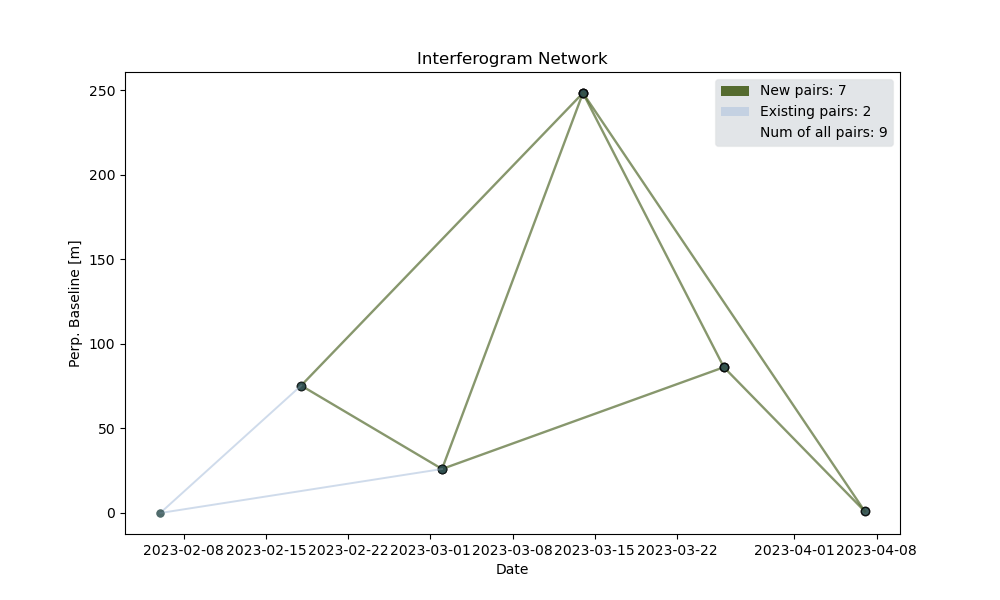

In [147]:
cmd = f'interferogramStack.py -s {isce_run_dir}'
for arg in ifg_args.keys():
    if ifg_args[arg]:
        if arg == 'force':
            cmd +=  ' ' + ifg_cmd_params[arg]
        else:
            cmd +=  ' ' + ifg_cmd_params[arg] + ' ' + str(ifg_args[arg])

print(cmd)
subprocess.run(cmd, shell=True)
display.Image(f'{isce_run_dir}/interferogram_network.png',width=1000, height=1000)

# List the run files
run_files = list(run_ifg_dir.glob('run_*'))
print(f'Number of run files: {len(run_files)}')
run_files

In [71]:
# Step 21 
# Directory: generate_burst_igram!
run_file = list(run_ifg_dir.glob('run_21*'))[0]
print(f'RUNNING {run_file}!')
run_file.chmod(33791)
out = subprocess.run(str(run_file), shell=True, check=True, stdout=subprocess.PIPE, close_fds=True)
print(out.stdout.decode("utf-8"))
print('STEP FINISHED - SUCESS!!!' if  out.returncode == 0 else 'STEP FINISHED - FAILED!!!')

RUNNING /u/trappist-r0/govorcin/CA/DSC/144/isce/run_ifg_files/run_21_generate_burst_igram!


KeyboardInterrupt: 

Traceback (most recent call last):
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/SentinelWrapper.py", line 251, in <module>
    main(args.start,args.end)
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/SentinelWrapper.py", line 242, in main
    cfgParser.runCmd()
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/SentinelWrapper.py", line 54, in runCmd
    func_modules.main(self.funcParams[section])
  File "/u/trappist0/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/generateIgram.py", line 205, in main
    intimage = multiply(referencename, secondaryname, intname,
  File "/u/trappist0/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/generateIgram.py", line 68, in multiply
    print('read')
BrokenPipeError: [Errno 32] Broken pipe


In [27]:
# Step 22
# Directory: _merge_burst_igram!
run_file = list(run_ifg_dir.glob('run_22*'))[0]
print(f'RUNNING {run_file}!')
run_file.chmod(33791)
out = subprocess.run(str(run_file), shell=True, check=True, stdout=subprocess.PIPE, close_fds=True)
print(out.stdout.decode("utf-8"))
print('STEP FINISHED - SUCESS!!!' if  out.returncode == 0 else 'STEP FINISHED - FAILED!!!')

RUNNING /u/trappist-r0/govorcin/CA/DSC/144/isce/run_ifg_files/run_22_merge_burst_igram!
Completed Parsing the Configuration file
Functions to be executed:
['Function-1']
Running: mergeBursts
['--stack', '/u/trappist-r0/govorcin/CA/DSC/144/isce/stack', '--inp_reference', '/u/trappist-r0/govorcin/CA/DSC/144/isce/interferograms/20230206_20230218', '--dirname', '/u/trappist-r0/govorcin/CA/DSC/144/isce/interferograms/20230206_20230218', '--name_pattern', 'fine*int', '--outfile', '/u/trappist-r0/govorcin/CA/DSC/144/isce/merged/interferograms/20230206_20230218/fine.int', '--method', 'top', '--aligned', '--valid_only', '--use_virtual_files', '--multilook', '--range_looks', '9', '--azimuth_looks', '3']
Updating the valid region of each burst to the common valid region of the stack
bursts:  1 14
Updating the valid region of each burst to the common valid region of the stack
bursts:  1 15
Updating the valid region of each burst to the common valid region of the stack
bursts:  1 14


Traceback (most recent call last):
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/SentinelWrapper.py", line 251, in <module>
    main(args.start,args.end)
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/SentinelWrapper.py", line 242, in main
    cfgParser.runCmd()
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/SentinelWrapper.py", line 54, in runCmd
    func_modules.main(self.funcParams[section])
  File "/u/trappist0/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/mergeBursts.py", line 415, in main
    mergeBurstsVirtual(frames, referenceFrames, fileList, inps.outfile+suffix, validOnly=inps.validOnly)
  File "/u/trappist0/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/mergeBursts.py", line 144, in mergeBurstsVirtual
    builder.addSwath(swath, relfilelist, band=bnd, validOnly=validOnly)
  File "/u/trappist0/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/VRTManager.py", line 158, in addSwath
  

Completed Parsing the Configuration file
Functions to be executed:
['Function-1']
Running: mergeBursts
['--stack', '/u/trappist-r0/govorcin/CA/DSC/144/isce/stack', '--inp_reference', '/u/trappist-r0/govorcin/CA/DSC/144/isce/interferograms/20230206_20230302', '--dirname', '/u/trappist-r0/govorcin/CA/DSC/144/isce/interferograms/20230206_20230302', '--name_pattern', 'fine*int', '--outfile', '/u/trappist-r0/govorcin/CA/DSC/144/isce/merged/interferograms/20230206_20230302/fine.int', '--method', 'top', '--aligned', '--valid_only', '--use_virtual_files', '--multilook', '--range_looks', '9', '--azimuth_looks', '3']
Updating the valid region of each burst to the common valid region of the stack
bursts:  1 14
Updating the valid region of each burst to the common valid region of the stack
bursts:  1 15
Updating the valid region of each burst to the common valid region of the stack
bursts:  1 14
Completed Parsing the Configuration file
Functions to be executed:
['Function-1']
Running: mergeBursts


Traceback (most recent call last):
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/SentinelWrapper.py", line 251, in <module>
    main(args.start,args.end)
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/SentinelWrapper.py", line 242, in main
    cfgParser.runCmd()
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/SentinelWrapper.py", line 54, in runCmd
    func_modules.main(self.funcParams[section])
  File "/u/trappist0/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/mergeBursts.py", line 415, in main
    mergeBurstsVirtual(frames, referenceFrames, fileList, inps.outfile+suffix, validOnly=inps.validOnly)
  File "/u/trappist0/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/mergeBursts.py", line 144, in mergeBurstsVirtual
    builder.addSwath(swath, relfilelist, band=bnd, validOnly=validOnly)
  File "/u/trappist0/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/VRTManager.py", line 158, in addSwath
  

Updating the valid region of each burst to the common valid region of the stack
bursts:  1 14
Updating the valid region of each burst to the common valid region of the stack
bursts:  1 15
Updating the valid region of each burst to the common valid region of the stack
bursts:  1 14
Completed Parsing the Configuration file
Functions to be executed:
['Function-1']
Running: mergeBursts
['--stack', '/u/trappist-r0/govorcin/CA/DSC/144/isce/stack', '--inp_reference', '/u/trappist-r0/govorcin/CA/DSC/144/isce/interferograms/20230218_20230314', '--dirname', '/u/trappist-r0/govorcin/CA/DSC/144/isce/interferograms/20230218_20230314', '--name_pattern', 'fine*int', '--outfile', '/u/trappist-r0/govorcin/CA/DSC/144/isce/merged/interferograms/20230218_20230314/fine.int', '--method', 'top', '--aligned', '--valid_only', '--use_virtual_files', '--multilook', '--range_looks', '9', '--azimuth_looks', '3']


Traceback (most recent call last):
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/SentinelWrapper.py", line 251, in <module>
    main(args.start,args.end)
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/SentinelWrapper.py", line 242, in main
    cfgParser.runCmd()
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/SentinelWrapper.py", line 54, in runCmd
    func_modules.main(self.funcParams[section])
  File "/u/trappist0/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/mergeBursts.py", line 415, in main
    mergeBurstsVirtual(frames, referenceFrames, fileList, inps.outfile+suffix, validOnly=inps.validOnly)
  File "/u/trappist0/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/mergeBursts.py", line 144, in mergeBurstsVirtual
    builder.addSwath(swath, relfilelist, band=bnd, validOnly=validOnly)
  File "/u/trappist0/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/VRTManager.py", line 158, in addSwath
  

Updating the valid region of each burst to the common valid region of the stack
bursts:  1 14
Updating the valid region of each burst to the common valid region of the stack
bursts:  1 15
Updating the valid region of each burst to the common valid region of the stack
bursts:  1 14
Completed Parsing the Configuration file
Functions to be executed:
['Function-1']
Running: mergeBursts
['--stack', '/u/trappist-r0/govorcin/CA/DSC/144/isce/stack', '--inp_reference', '/u/trappist-r0/govorcin/CA/DSC/144/isce/interferograms/20230302_20230314', '--dirname', '/u/trappist-r0/govorcin/CA/DSC/144/isce/interferograms/20230302_20230314', '--name_pattern', 'fine*int', '--outfile', '/u/trappist-r0/govorcin/CA/DSC/144/isce/merged/interferograms/20230302_20230314/fine.int', '--method', 'top', '--aligned', '--valid_only', '--use_virtual_files', '--multilook', '--range_looks', '9', '--azimuth_looks', '3']


Traceback (most recent call last):
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/SentinelWrapper.py", line 251, in <module>
    main(args.start,args.end)
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/SentinelWrapper.py", line 242, in main
    cfgParser.runCmd()
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/SentinelWrapper.py", line 54, in runCmd
    func_modules.main(self.funcParams[section])
  File "/u/trappist0/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/mergeBursts.py", line 415, in main
    mergeBurstsVirtual(frames, referenceFrames, fileList, inps.outfile+suffix, validOnly=inps.validOnly)
  File "/u/trappist0/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/mergeBursts.py", line 144, in mergeBurstsVirtual
    builder.addSwath(swath, relfilelist, band=bnd, validOnly=validOnly)
  File "/u/trappist0/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/VRTManager.py", line 158, in addSwath
  

Updating the valid region of each burst to the common valid region of the stack
bursts:  1 14
Updating the valid region of each burst to the common valid region of the stack
bursts:  1 15
Updating the valid region of each burst to the common valid region of the stack
bursts:  1 14
Completed Parsing the Configuration file
Functions to be executed:
['Function-1']
Running: mergeBursts
['--stack', '/u/trappist-r0/govorcin/CA/DSC/144/isce/stack', '--inp_reference', '/u/trappist-r0/govorcin/CA/DSC/144/isce/interferograms/20230302_20230326', '--dirname', '/u/trappist-r0/govorcin/CA/DSC/144/isce/interferograms/20230302_20230326', '--name_pattern', 'fine*int', '--outfile', '/u/trappist-r0/govorcin/CA/DSC/144/isce/merged/interferograms/20230302_20230326/fine.int', '--method', 'top', '--aligned', '--valid_only', '--use_virtual_files', '--multilook', '--range_looks', '9', '--azimuth_looks', '3']


Traceback (most recent call last):
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/SentinelWrapper.py", line 251, in <module>
    main(args.start,args.end)
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/SentinelWrapper.py", line 242, in main
    cfgParser.runCmd()
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/SentinelWrapper.py", line 54, in runCmd
    func_modules.main(self.funcParams[section])
  File "/u/trappist0/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/mergeBursts.py", line 415, in main
    mergeBurstsVirtual(frames, referenceFrames, fileList, inps.outfile+suffix, validOnly=inps.validOnly)
  File "/u/trappist0/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/mergeBursts.py", line 144, in mergeBurstsVirtual
    builder.addSwath(swath, relfilelist, band=bnd, validOnly=validOnly)
  File "/u/trappist0/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/VRTManager.py", line 158, in addSwath
  

Updating the valid region of each burst to the common valid region of the stack
bursts:  1 14
Updating the valid region of each burst to the common valid region of the stack
bursts:  1 15
Updating the valid region of each burst to the common valid region of the stack
bursts:  1 14
Completed Parsing the Configuration file
Functions to be executed:
['Function-1']
Running: mergeBursts
['--stack', '/u/trappist-r0/govorcin/CA/DSC/144/isce/stack', '--inp_reference', '/u/trappist-r0/govorcin/CA/DSC/144/isce/interferograms/20230314_20230326', '--dirname', '/u/trappist-r0/govorcin/CA/DSC/144/isce/interferograms/20230314_20230326', '--name_pattern', 'fine*int', '--outfile', '/u/trappist-r0/govorcin/CA/DSC/144/isce/merged/interferograms/20230314_20230326/fine.int', '--method', 'top', '--aligned', '--valid_only', '--use_virtual_files', '--multilook', '--range_looks', '9', '--azimuth_looks', '3']


Traceback (most recent call last):
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/SentinelWrapper.py", line 251, in <module>
    main(args.start,args.end)
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/SentinelWrapper.py", line 242, in main
    cfgParser.runCmd()
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/SentinelWrapper.py", line 54, in runCmd
    func_modules.main(self.funcParams[section])
  File "/u/trappist0/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/mergeBursts.py", line 415, in main
    mergeBurstsVirtual(frames, referenceFrames, fileList, inps.outfile+suffix, validOnly=inps.validOnly)
  File "/u/trappist0/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/mergeBursts.py", line 144, in mergeBurstsVirtual
    builder.addSwath(swath, relfilelist, band=bnd, validOnly=validOnly)
  File "/u/trappist0/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/VRTManager.py", line 158, in addSwath
  

Updating the valid region of each burst to the common valid region of the stack
bursts:  1 14
Updating the valid region of each burst to the common valid region of the stack
bursts:  1 15
Updating the valid region of each burst to the common valid region of the stack
bursts:  1 14
Completed Parsing the Configuration file
Functions to be executed:
['Function-1']
Running: mergeBursts
['--stack', '/u/trappist-r0/govorcin/CA/DSC/144/isce/stack', '--inp_reference', '/u/trappist-r0/govorcin/CA/DSC/144/isce/interferograms/20230314_20230407', '--dirname', '/u/trappist-r0/govorcin/CA/DSC/144/isce/interferograms/20230314_20230407', '--name_pattern', 'fine*int', '--outfile', '/u/trappist-r0/govorcin/CA/DSC/144/isce/merged/interferograms/20230314_20230407/fine.int', '--method', 'top', '--aligned', '--valid_only', '--use_virtual_files', '--multilook', '--range_looks', '9', '--azimuth_looks', '3']


Traceback (most recent call last):
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/SentinelWrapper.py", line 251, in <module>
    main(args.start,args.end)
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/SentinelWrapper.py", line 242, in main
    cfgParser.runCmd()
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/SentinelWrapper.py", line 54, in runCmd
    func_modules.main(self.funcParams[section])
  File "/u/trappist0/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/mergeBursts.py", line 415, in main
    mergeBurstsVirtual(frames, referenceFrames, fileList, inps.outfile+suffix, validOnly=inps.validOnly)
  File "/u/trappist0/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/mergeBursts.py", line 144, in mergeBurstsVirtual
    builder.addSwath(swath, relfilelist, band=bnd, validOnly=validOnly)
  File "/u/trappist0/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/VRTManager.py", line 158, in addSwath
  

Updating the valid region of each burst to the common valid region of the stack
bursts:  1 14
Updating the valid region of each burst to the common valid region of the stack
bursts:  1 15
Updating the valid region of each burst to the common valid region of the stack
bursts:  1 14
Completed Parsing the Configuration file
Functions to be executed:
['Function-1']
Running: mergeBursts
['--stack', '/u/trappist-r0/govorcin/CA/DSC/144/isce/stack', '--inp_reference', '/u/trappist-r0/govorcin/CA/DSC/144/isce/interferograms/20230326_20230407', '--dirname', '/u/trappist-r0/govorcin/CA/DSC/144/isce/interferograms/20230326_20230407', '--name_pattern', 'fine*int', '--outfile', '/u/trappist-r0/govorcin/CA/DSC/144/isce/merged/interferograms/20230326_20230407/fine.int', '--method', 'top', '--aligned', '--valid_only', '--use_virtual_files', '--multilook', '--range_looks', '9', '--azimuth_looks', '3']


Traceback (most recent call last):
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/SentinelWrapper.py", line 251, in <module>
    main(args.start,args.end)
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/SentinelWrapper.py", line 242, in main
    cfgParser.runCmd()
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/SentinelWrapper.py", line 54, in runCmd
    func_modules.main(self.funcParams[section])
  File "/u/trappist0/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/mergeBursts.py", line 415, in main
    mergeBurstsVirtual(frames, referenceFrames, fileList, inps.outfile+suffix, validOnly=inps.validOnly)
  File "/u/trappist0/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/mergeBursts.py", line 144, in mergeBurstsVirtual
    builder.addSwath(swath, relfilelist, band=bnd, validOnly=validOnly)
  File "/u/trappist0/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/VRTManager.py", line 158, in addSwath
  

Updating the valid region of each burst to the common valid region of the stack
bursts:  1 14
Updating the valid region of each burst to the common valid region of the stack
bursts:  1 15
Updating the valid region of each burst to the common valid region of the stack
bursts:  1 14


Traceback (most recent call last):
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/SentinelWrapper.py", line 251, in <module>
    main(args.start,args.end)
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/SentinelWrapper.py", line 242, in main
    cfgParser.runCmd()
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/SentinelWrapper.py", line 54, in runCmd
    func_modules.main(self.funcParams[section])
  File "/u/trappist0/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/mergeBursts.py", line 415, in main
    mergeBurstsVirtual(frames, referenceFrames, fileList, inps.outfile+suffix, validOnly=inps.validOnly)
  File "/u/trappist0/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/mergeBursts.py", line 144, in mergeBurstsVirtual
    builder.addSwath(swath, relfilelist, band=bnd, validOnly=validOnly)
  File "/u/trappist0/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/VRTManager.py", line 158, in addSwath
  

CompletedProcess(args='/u/trappist-r0/govorcin/CA/DSC/144/isce/run_ifg_files/run_22_merge_burst_igram', returncode=1)

In [26]:
# Step 23
# Directory: filter_coherence!
run_file = list(run_ifg_dir.glob('run_23*'))[0]
print(f'RUNNING {run_file}!')
run_file.chmod(33791)
out = subprocess.run(str(run_file), shell=True, check=True, stdout=subprocess.PIPE, close_fds=True)
print(out.stdout.decode("utf-8"))
print('STEP FINISHED - SUCESS!!!' if  out.returncode == 0 else 'STEP FINISHED - FAILED!!!')

RUNNING /u/trappist-r0/govorcin/CA/DSC/144/isce/run_ifg_files/run_23_filter_coherence!
Completed Parsing the Configuration file
Functions to be executed:
['Function-1']
Running: FilterAndCoherence
['--input', '/u/trappist-r0/govorcin/CA/DSC/144/isce/merged/interferograms/20230206_20230218/fine.int', '--filt', '/u/trappist-r0/govorcin/CA/DSC/144/isce/merged/interferograms/20230206_20230218/filt_fine.int', '--coh', '/u/trappist-r0/govorcin/CA/DSC/144/isce/merged/interferograms/20230206_20230218/filt_fine.cor', '--strength', '0.5', '--slc1', '/u/trappist-r0/govorcin/CA/DSC/144/isce/merged/SLC/20230206/20230206.slc.full', '--slc2', '/u/trappist-r0/govorcin/CA/DSC/144/isce/merged/SLC/20230218/20230218.slc.full', '--complex_coh', '/u/trappist-r0/govorcin/CA/DSC/144/isce/merged/interferograms/20230206_20230218/fine.cor', '--range_looks', '9', '--azimuth_looks', '3']
2023-05-23 15:33:28,988 - isce.tops.runFilter - INFO - Applying power-spectral filter


Traceback (most recent call last):
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/SentinelWrapper.py", line 251, in <module>
    main(args.start,args.end)
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/SentinelWrapper.py", line 242, in main
    cfgParser.runCmd()
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/SentinelWrapper.py", line 54, in runCmd
    func_modules.main(self.funcParams[section])
  File "/u/trappist0/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/FilterAndCoherence.py", line 192, in main
    runFilter(inps.infile, inps.filtfile, inps.filterstrength)
  File "/u/trappist0/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/FilterAndCoherence.py", line 48, in runFilter
    intImage.load( infile + '.xml')
  File "/home/govorcin/tools/miniconda3/envs/insar/lib/python3.8/site-packages/isce/components/iscesys/Component/Configurable.py", line 1407, in load
    tmpProp, tmpFact, tmpMisc = FP.parse(

Completed Parsing the Configuration file
Functions to be executed:
['Function-1']
Running: FilterAndCoherence
['--input', '/u/trappist-r0/govorcin/CA/DSC/144/isce/merged/interferograms/20230206_20230302/fine.int', '--filt', '/u/trappist-r0/govorcin/CA/DSC/144/isce/merged/interferograms/20230206_20230302/filt_fine.int', '--coh', '/u/trappist-r0/govorcin/CA/DSC/144/isce/merged/interferograms/20230206_20230302/filt_fine.cor', '--strength', '0.5', '--slc1', '/u/trappist-r0/govorcin/CA/DSC/144/isce/merged/SLC/20230206/20230206.slc.full', '--slc2', '/u/trappist-r0/govorcin/CA/DSC/144/isce/merged/SLC/20230302/20230302.slc.full', '--complex_coh', '/u/trappist-r0/govorcin/CA/DSC/144/isce/merged/interferograms/20230206_20230302/fine.cor', '--range_looks', '9', '--azimuth_looks', '3']
2023-05-23 15:33:29,178 - isce.tops.runFilter - INFO - Applying power-spectral filter
Completed Parsing the Configuration file
Functions to be executed:
['Function-1']
Running: FilterAndCoherence
['--input', '/u/tra

Traceback (most recent call last):
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/SentinelWrapper.py", line 251, in <module>
    main(args.start,args.end)
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/SentinelWrapper.py", line 242, in main
    cfgParser.runCmd()
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/SentinelWrapper.py", line 54, in runCmd
    func_modules.main(self.funcParams[section])
  File "/u/trappist0/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/FilterAndCoherence.py", line 192, in main
    runFilter(inps.infile, inps.filtfile, inps.filterstrength)
  File "/u/trappist0/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/FilterAndCoherence.py", line 48, in runFilter
    intImage.load( infile + '.xml')
  File "/home/govorcin/tools/miniconda3/envs/insar/lib/python3.8/site-packages/isce/components/iscesys/Component/Configurable.py", line 1407, in load
    tmpProp, tmpFact, tmpMisc = FP.parse(

Completed Parsing the Configuration file
Functions to be executed:
['Function-1']
Running: FilterAndCoherence
['--input', '/u/trappist-r0/govorcin/CA/DSC/144/isce/merged/interferograms/20230218_20230314/fine.int', '--filt', '/u/trappist-r0/govorcin/CA/DSC/144/isce/merged/interferograms/20230218_20230314/filt_fine.int', '--coh', '/u/trappist-r0/govorcin/CA/DSC/144/isce/merged/interferograms/20230218_20230314/filt_fine.cor', '--strength', '0.5', '--slc1', '/u/trappist-r0/govorcin/CA/DSC/144/isce/merged/SLC/20230218/20230218.slc.full', '--slc2', '/u/trappist-r0/govorcin/CA/DSC/144/isce/merged/SLC/20230314/20230314.slc.full', '--complex_coh', '/u/trappist-r0/govorcin/CA/DSC/144/isce/merged/interferograms/20230218_20230314/fine.cor', '--range_looks', '9', '--azimuth_looks', '3']
2023-05-23 15:33:29,479 - isce.tops.runFilter - INFO - Applying power-spectral filter
Completed Parsing the Configuration file
Functions to be executed:
['Function-1']
Running: FilterAndCoherence
['--input', '/u/tra

Traceback (most recent call last):
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/SentinelWrapper.py", line 251, in <module>
    main(args.start,args.end)
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/SentinelWrapper.py", line 242, in main
    cfgParser.runCmd()
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/SentinelWrapper.py", line 54, in runCmd
    func_modules.main(self.funcParams[section])
  File "/u/trappist0/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/FilterAndCoherence.py", line 192, in main
    runFilter(inps.infile, inps.filtfile, inps.filterstrength)
  File "/u/trappist0/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/FilterAndCoherence.py", line 48, in runFilter
    intImage.load( infile + '.xml')
  File "/home/govorcin/tools/miniconda3/envs/insar/lib/python3.8/site-packages/isce/components/iscesys/Component/Configurable.py", line 1407, in load
    tmpProp, tmpFact, tmpMisc = FP.parse(

Completed Parsing the Configuration file
Functions to be executed:
['Function-1']
Running: FilterAndCoherence
['--input', '/u/trappist-r0/govorcin/CA/DSC/144/isce/merged/interferograms/20230302_20230326/fine.int', '--filt', '/u/trappist-r0/govorcin/CA/DSC/144/isce/merged/interferograms/20230302_20230326/filt_fine.int', '--coh', '/u/trappist-r0/govorcin/CA/DSC/144/isce/merged/interferograms/20230302_20230326/filt_fine.cor', '--strength', '0.5', '--slc1', '/u/trappist-r0/govorcin/CA/DSC/144/isce/merged/SLC/20230302/20230302.slc.full', '--slc2', '/u/trappist-r0/govorcin/CA/DSC/144/isce/merged/SLC/20230326/20230326.slc.full', '--complex_coh', '/u/trappist-r0/govorcin/CA/DSC/144/isce/merged/interferograms/20230302_20230326/fine.cor', '--range_looks', '9', '--azimuth_looks', '3']
2023-05-23 15:33:29,782 - isce.tops.runFilter - INFO - Applying power-spectral filter
Completed Parsing the Configuration file
Functions to be executed:
['Function-1']
Running: FilterAndCoherence
['--input', '/u/tra

Traceback (most recent call last):
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/SentinelWrapper.py", line 251, in <module>
    main(args.start,args.end)
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/SentinelWrapper.py", line 242, in main
    cfgParser.runCmd()
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/SentinelWrapper.py", line 54, in runCmd
    func_modules.main(self.funcParams[section])
  File "/u/trappist0/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/FilterAndCoherence.py", line 192, in main
    runFilter(inps.infile, inps.filtfile, inps.filterstrength)
  File "/u/trappist0/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/FilterAndCoherence.py", line 48, in runFilter
    intImage.load( infile + '.xml')
  File "/home/govorcin/tools/miniconda3/envs/insar/lib/python3.8/site-packages/isce/components/iscesys/Component/Configurable.py", line 1407, in load
    tmpProp, tmpFact, tmpMisc = FP.parse(

Completed Parsing the Configuration file
Functions to be executed:
['Function-1']
Running: FilterAndCoherence
['--input', '/u/trappist-r0/govorcin/CA/DSC/144/isce/merged/interferograms/20230314_20230407/fine.int', '--filt', '/u/trappist-r0/govorcin/CA/DSC/144/isce/merged/interferograms/20230314_20230407/filt_fine.int', '--coh', '/u/trappist-r0/govorcin/CA/DSC/144/isce/merged/interferograms/20230314_20230407/filt_fine.cor', '--strength', '0.5', '--slc1', '/u/trappist-r0/govorcin/CA/DSC/144/isce/merged/SLC/20230314/20230314.slc.full', '--slc2', '/u/trappist-r0/govorcin/CA/DSC/144/isce/merged/SLC/20230407/20230407.slc.full', '--complex_coh', '/u/trappist-r0/govorcin/CA/DSC/144/isce/merged/interferograms/20230314_20230407/fine.cor', '--range_looks', '9', '--azimuth_looks', '3']
2023-05-23 15:33:30,103 - isce.tops.runFilter - INFO - Applying power-spectral filter
Completed Parsing the Configuration file
Functions to be executed:
['Function-1']
Running: FilterAndCoherence
['--input', '/u/tra

Traceback (most recent call last):
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/SentinelWrapper.py", line 251, in <module>
    main(args.start,args.end)
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/SentinelWrapper.py", line 242, in main
    cfgParser.runCmd()
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/SentinelWrapper.py", line 54, in runCmd
    func_modules.main(self.funcParams[section])
  File "/u/trappist0/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/FilterAndCoherence.py", line 192, in main
    runFilter(inps.infile, inps.filtfile, inps.filterstrength)
  File "/u/trappist0/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/FilterAndCoherence.py", line 48, in runFilter
    intImage.load( infile + '.xml')
  File "/home/govorcin/tools/miniconda3/envs/insar/lib/python3.8/site-packages/isce/components/iscesys/Component/Configurable.py", line 1407, in load
    tmpProp, tmpFact, tmpMisc = FP.parse(

CompletedProcess(args='/u/trappist-r0/govorcin/CA/DSC/144/isce/run_ifg_files/run_23_filter_coherence', returncode=1)

In [25]:
# Step 24
# Directory: coarse_interferograms
run_file = list(run_ifg_dir.glob('run_24*'))[0]
print(f'RUNNING {run_file}!')
run_file.chmod(33791)
out = subprocess.run(str(run_file), shell=True, check=True, stdout=subprocess.PIPE, close_fds=True)
print(out.stdout.decode("utf-8"))
print('STEP FINISHED - SUCESS!!!' if  out.returncode == 0 else 'STEP FINISHED - FAILED!!!')

RUNNING /u/trappist-r0/govorcin/CA/DSC/144/isce/run_ifg_files/run_24_unwrap!
Completed Parsing the Configuration file
Functions to be executed:
['Function-1']
Running: unwrap
['--ifg', '/u/trappist-r0/govorcin/CA/DSC/144/isce/merged/interferograms/20230206_20230218/filt_fine.int', '--unw', '/u/trappist-r0/govorcin/CA/DSC/144/isce/merged/interferograms/20230206_20230218/filt_fine.unw', '--coh', '/u/trappist-r0/govorcin/CA/DSC/144/isce/merged/interferograms/20230206_20230218/filt_fine.cor', '--reference', '/u/trappist-r0/govorcin/CA/DSC/144/isce/reference', '--defomax', '2', '--rlks', '9', '--alks', '3', '--method', 'snaphu']
unwrapping method :  snaphu


Traceback (most recent call last):
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/SentinelWrapper.py", line 251, in <module>
    main(args.start,args.end)
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/SentinelWrapper.py", line 242, in main
    cfgParser.runCmd()
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/SentinelWrapper.py", line 54, in runCmd
    func_modules.main(self.funcParams[section])
  File "/u/trappist0/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/unwrap.py", line 328, in main
    fncall(inps.intfile, inps.unwfile, inps.cohfile, metadata, defomax=inps.defomax)
  File "/u/trappist0/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/unwrap.py", line 237, in runUnwrapMcf
    runUnwrap(infile, outfile, corfile, config, costMode = 'SMOOTH',initMethod = 'MCF', defomax = defomax, initOnly = True)
  File "/u/trappist0/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/unwrap.py", line 170, in

Completed Parsing the Configuration file
Functions to be executed:
['Function-1']
Running: unwrap
['--ifg', '/u/trappist-r0/govorcin/CA/DSC/144/isce/merged/interferograms/20230206_20230302/filt_fine.int', '--unw', '/u/trappist-r0/govorcin/CA/DSC/144/isce/merged/interferograms/20230206_20230302/filt_fine.unw', '--coh', '/u/trappist-r0/govorcin/CA/DSC/144/isce/merged/interferograms/20230206_20230302/filt_fine.cor', '--reference', '/u/trappist-r0/govorcin/CA/DSC/144/isce/reference', '--defomax', '2', '--rlks', '9', '--alks', '3', '--method', 'snaphu']
unwrapping method :  snaphu


Traceback (most recent call last):
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/SentinelWrapper.py", line 251, in <module>
    main(args.start,args.end)
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/SentinelWrapper.py", line 242, in main
    cfgParser.runCmd()
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/SentinelWrapper.py", line 54, in runCmd
    func_modules.main(self.funcParams[section])
  File "/u/trappist0/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/unwrap.py", line 328, in main
    fncall(inps.intfile, inps.unwfile, inps.cohfile, metadata, defomax=inps.defomax)
  File "/u/trappist0/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/unwrap.py", line 237, in runUnwrapMcf
    runUnwrap(infile, outfile, corfile, config, costMode = 'SMOOTH',initMethod = 'MCF', defomax = defomax, initOnly = True)
  File "/u/trappist0/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/unwrap.py", line 170, in

Completed Parsing the Configuration file
Functions to be executed:
['Function-1']
Running: unwrap
['--ifg', '/u/trappist-r0/govorcin/CA/DSC/144/isce/merged/interferograms/20230218_20230302/filt_fine.int', '--unw', '/u/trappist-r0/govorcin/CA/DSC/144/isce/merged/interferograms/20230218_20230302/filt_fine.unw', '--coh', '/u/trappist-r0/govorcin/CA/DSC/144/isce/merged/interferograms/20230218_20230302/filt_fine.cor', '--reference', '/u/trappist-r0/govorcin/CA/DSC/144/isce/reference', '--defomax', '2', '--rlks', '9', '--alks', '3', '--method', 'snaphu']
unwrapping method :  snaphu


Traceback (most recent call last):
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/SentinelWrapper.py", line 251, in <module>
    main(args.start,args.end)
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/SentinelWrapper.py", line 242, in main
    cfgParser.runCmd()
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/SentinelWrapper.py", line 54, in runCmd
    func_modules.main(self.funcParams[section])
  File "/u/trappist0/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/unwrap.py", line 328, in main
    fncall(inps.intfile, inps.unwfile, inps.cohfile, metadata, defomax=inps.defomax)
  File "/u/trappist0/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/unwrap.py", line 237, in runUnwrapMcf
    runUnwrap(infile, outfile, corfile, config, costMode = 'SMOOTH',initMethod = 'MCF', defomax = defomax, initOnly = True)
  File "/u/trappist0/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/unwrap.py", line 170, in

Completed Parsing the Configuration file
Functions to be executed:
['Function-1']
Running: unwrap
['--ifg', '/u/trappist-r0/govorcin/CA/DSC/144/isce/merged/interferograms/20230218_20230314/filt_fine.int', '--unw', '/u/trappist-r0/govorcin/CA/DSC/144/isce/merged/interferograms/20230218_20230314/filt_fine.unw', '--coh', '/u/trappist-r0/govorcin/CA/DSC/144/isce/merged/interferograms/20230218_20230314/filt_fine.cor', '--reference', '/u/trappist-r0/govorcin/CA/DSC/144/isce/reference', '--defomax', '2', '--rlks', '9', '--alks', '3', '--method', 'snaphu']
unwrapping method :  snaphu


Traceback (most recent call last):
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/SentinelWrapper.py", line 251, in <module>
    main(args.start,args.end)
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/SentinelWrapper.py", line 242, in main
    cfgParser.runCmd()
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/SentinelWrapper.py", line 54, in runCmd
    func_modules.main(self.funcParams[section])
  File "/u/trappist0/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/unwrap.py", line 328, in main
    fncall(inps.intfile, inps.unwfile, inps.cohfile, metadata, defomax=inps.defomax)
  File "/u/trappist0/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/unwrap.py", line 237, in runUnwrapMcf
    runUnwrap(infile, outfile, corfile, config, costMode = 'SMOOTH',initMethod = 'MCF', defomax = defomax, initOnly = True)
  File "/u/trappist0/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/unwrap.py", line 170, in

Completed Parsing the Configuration file
Functions to be executed:
['Function-1']
Running: unwrap
['--ifg', '/u/trappist-r0/govorcin/CA/DSC/144/isce/merged/interferograms/20230302_20230314/filt_fine.int', '--unw', '/u/trappist-r0/govorcin/CA/DSC/144/isce/merged/interferograms/20230302_20230314/filt_fine.unw', '--coh', '/u/trappist-r0/govorcin/CA/DSC/144/isce/merged/interferograms/20230302_20230314/filt_fine.cor', '--reference', '/u/trappist-r0/govorcin/CA/DSC/144/isce/reference', '--defomax', '2', '--rlks', '9', '--alks', '3', '--method', 'snaphu']
unwrapping method :  snaphu


Traceback (most recent call last):
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/SentinelWrapper.py", line 251, in <module>
    main(args.start,args.end)
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/SentinelWrapper.py", line 242, in main
    cfgParser.runCmd()
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/SentinelWrapper.py", line 54, in runCmd
    func_modules.main(self.funcParams[section])
  File "/u/trappist0/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/unwrap.py", line 328, in main
    fncall(inps.intfile, inps.unwfile, inps.cohfile, metadata, defomax=inps.defomax)
  File "/u/trappist0/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/unwrap.py", line 237, in runUnwrapMcf
    runUnwrap(infile, outfile, corfile, config, costMode = 'SMOOTH',initMethod = 'MCF', defomax = defomax, initOnly = True)
  File "/u/trappist0/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/unwrap.py", line 170, in

Completed Parsing the Configuration file
Functions to be executed:
['Function-1']
Running: unwrap
['--ifg', '/u/trappist-r0/govorcin/CA/DSC/144/isce/merged/interferograms/20230302_20230326/filt_fine.int', '--unw', '/u/trappist-r0/govorcin/CA/DSC/144/isce/merged/interferograms/20230302_20230326/filt_fine.unw', '--coh', '/u/trappist-r0/govorcin/CA/DSC/144/isce/merged/interferograms/20230302_20230326/filt_fine.cor', '--reference', '/u/trappist-r0/govorcin/CA/DSC/144/isce/reference', '--defomax', '2', '--rlks', '9', '--alks', '3', '--method', 'snaphu']
unwrapping method :  snaphu


Traceback (most recent call last):
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/SentinelWrapper.py", line 251, in <module>
    main(args.start,args.end)
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/SentinelWrapper.py", line 242, in main
    cfgParser.runCmd()
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/SentinelWrapper.py", line 54, in runCmd
    func_modules.main(self.funcParams[section])
  File "/u/trappist0/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/unwrap.py", line 328, in main
    fncall(inps.intfile, inps.unwfile, inps.cohfile, metadata, defomax=inps.defomax)
  File "/u/trappist0/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/unwrap.py", line 237, in runUnwrapMcf
    runUnwrap(infile, outfile, corfile, config, costMode = 'SMOOTH',initMethod = 'MCF', defomax = defomax, initOnly = True)
  File "/u/trappist0/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/unwrap.py", line 170, in

Completed Parsing the Configuration file
Functions to be executed:
['Function-1']
Running: unwrap
['--ifg', '/u/trappist-r0/govorcin/CA/DSC/144/isce/merged/interferograms/20230314_20230326/filt_fine.int', '--unw', '/u/trappist-r0/govorcin/CA/DSC/144/isce/merged/interferograms/20230314_20230326/filt_fine.unw', '--coh', '/u/trappist-r0/govorcin/CA/DSC/144/isce/merged/interferograms/20230314_20230326/filt_fine.cor', '--reference', '/u/trappist-r0/govorcin/CA/DSC/144/isce/reference', '--defomax', '2', '--rlks', '9', '--alks', '3', '--method', 'snaphu']
unwrapping method :  snaphu


Traceback (most recent call last):
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/SentinelWrapper.py", line 251, in <module>
    main(args.start,args.end)
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/SentinelWrapper.py", line 242, in main
    cfgParser.runCmd()
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/SentinelWrapper.py", line 54, in runCmd
    func_modules.main(self.funcParams[section])
  File "/u/trappist0/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/unwrap.py", line 328, in main
    fncall(inps.intfile, inps.unwfile, inps.cohfile, metadata, defomax=inps.defomax)
  File "/u/trappist0/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/unwrap.py", line 237, in runUnwrapMcf
    runUnwrap(infile, outfile, corfile, config, costMode = 'SMOOTH',initMethod = 'MCF', defomax = defomax, initOnly = True)
  File "/u/trappist0/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/unwrap.py", line 170, in

Completed Parsing the Configuration file
Functions to be executed:
['Function-1']
Running: unwrap
['--ifg', '/u/trappist-r0/govorcin/CA/DSC/144/isce/merged/interferograms/20230314_20230407/filt_fine.int', '--unw', '/u/trappist-r0/govorcin/CA/DSC/144/isce/merged/interferograms/20230314_20230407/filt_fine.unw', '--coh', '/u/trappist-r0/govorcin/CA/DSC/144/isce/merged/interferograms/20230314_20230407/filt_fine.cor', '--reference', '/u/trappist-r0/govorcin/CA/DSC/144/isce/reference', '--defomax', '2', '--rlks', '9', '--alks', '3', '--method', 'snaphu']
unwrapping method :  snaphu


Traceback (most recent call last):
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/SentinelWrapper.py", line 251, in <module>
    main(args.start,args.end)
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/SentinelWrapper.py", line 242, in main
    cfgParser.runCmd()
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/SentinelWrapper.py", line 54, in runCmd
    func_modules.main(self.funcParams[section])
  File "/u/trappist0/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/unwrap.py", line 328, in main
    fncall(inps.intfile, inps.unwfile, inps.cohfile, metadata, defomax=inps.defomax)
  File "/u/trappist0/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/unwrap.py", line 237, in runUnwrapMcf
    runUnwrap(infile, outfile, corfile, config, costMode = 'SMOOTH',initMethod = 'MCF', defomax = defomax, initOnly = True)
  File "/u/trappist0/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/unwrap.py", line 170, in

Completed Parsing the Configuration file
Functions to be executed:
['Function-1']
Running: unwrap
['--ifg', '/u/trappist-r0/govorcin/CA/DSC/144/isce/merged/interferograms/20230326_20230407/filt_fine.int', '--unw', '/u/trappist-r0/govorcin/CA/DSC/144/isce/merged/interferograms/20230326_20230407/filt_fine.unw', '--coh', '/u/trappist-r0/govorcin/CA/DSC/144/isce/merged/interferograms/20230326_20230407/filt_fine.cor', '--reference', '/u/trappist-r0/govorcin/CA/DSC/144/isce/reference', '--defomax', '2', '--rlks', '9', '--alks', '3', '--method', 'snaphu']
unwrapping method :  snaphu


Traceback (most recent call last):
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/SentinelWrapper.py", line 251, in <module>
    main(args.start,args.end)
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/SentinelWrapper.py", line 242, in main
    cfgParser.runCmd()
  File "/home/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/SentinelWrapper.py", line 54, in runCmd
    func_modules.main(self.funcParams[section])
  File "/u/trappist0/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/unwrap.py", line 328, in main
    fncall(inps.intfile, inps.unwfile, inps.cohfile, metadata, defomax=inps.defomax)
  File "/u/trappist0/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/unwrap.py", line 237, in runUnwrapMcf
    runUnwrap(infile, outfile, corfile, config, costMode = 'SMOOTH',initMethod = 'MCF', defomax = defomax, initOnly = True)
  File "/u/trappist0/govorcin/tools/isce22/src/isce2/contrib/stack/topsStack/unwrap.py", line 170, in

CompletedProcess(args='/u/trappist-r0/govorcin/CA/DSC/144/isce/run_ifg_files/run_24_unwrap', returncode=1)

# Process more interferograms

In [11]:
# Lets change network to delaunay
ifg_args['network'] = 'delaunay'

In [12]:
cmd = f'interferogramStack.py -s {isce_run_dir}'
for arg in ifg_args.keys():
    if ifg_args[arg]:
        if arg == 'force':
            cmd +=  ' ' + ifg_cmd_params[arg]
        else:
            cmd +=  ' ' + ifg_cmd_params[arg] + ' ' + str(ifg_args[arg])

print(cmd)
subprocess.run(cmd, shell=True)

# List the run files
run_files = list(run_ifg_dir.glob('run_*'))
print(f'Number of run files: {len(run_files)}')
run_files

interferogramStack.py -s /u/trappist-r0/govorcin/CA/DSC/144/isce -n delaunay -c 2 -pt 5 -z 3 -r 9 -f 0.5 -u snaphu --force

**************************
run_ifg_files folder exists.
/u/trappist-r0/govorcin/CA/DSC/144/isce/run_ifg_files  already exists.
Deleting all existing run_files in this folder.

**************************
True
2023-06-05 09:14:53,236 - matplotlib - DEBUG - matplotlib data path: /home/govorcin/tools/miniconda3/envs/insar/lib/python3.8/site-packages/matplotlib/mpl-data
2023-06-05 09:14:53,259 - matplotlib - DEBUG - CONFIGDIR=/home/govorcin/.config/matplotlib
2023-06-05 09:14:53,260 - matplotlib - DEBUG - interactive is False
2023-06-05 09:14:53,260 - matplotlib - DEBUG - platform is linux
2023-06-05 09:14:53,311 - matplotlib - DEBUG - CACHEDIR=/home/govorcin/.cache/matplotlib
2023-06-05 09:14:53,314 - matplotlib.font_manager - DEBUG - Using fontManager instance from /home/govorcin/.cache/matplotlib/fontlist-v330.json
2023-06-05 09:14:53,465 - matplotlib.pyplot - DEBUG

[PosixPath('/u/trappist-r0/govorcin/CA/DSC/144/isce/run_ifg_files/run_21_generate_burst_igram'),
 PosixPath('/u/trappist-r0/govorcin/CA/DSC/144/isce/run_ifg_files/run_22_merge_burst_igram'),
 PosixPath('/u/trappist-r0/govorcin/CA/DSC/144/isce/run_ifg_files/run_23_filter_coherence'),
 PosixPath('/u/trappist-r0/govorcin/CA/DSC/144/isce/run_ifg_files/run_24_unwrap')]

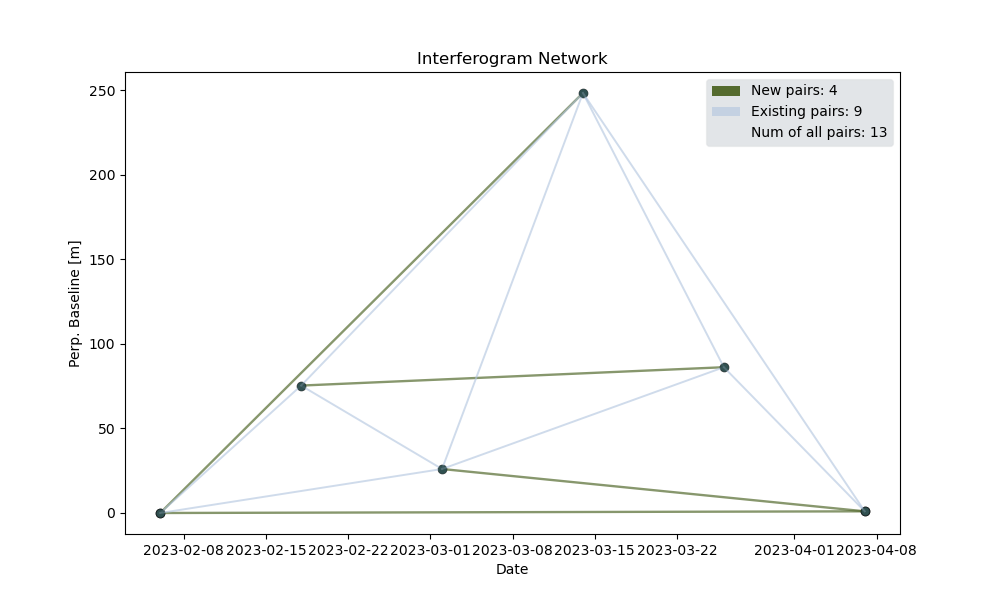

In [13]:
display.Image(f'{isce_run_dir}/interferogram_network.png',width=500, height=500)